152


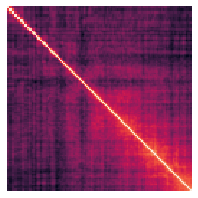

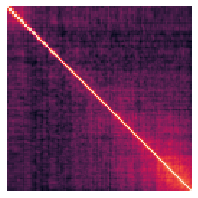

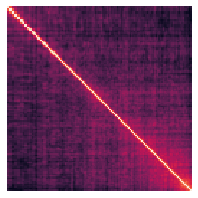

In [1]:
import csv
import torch
import torchvision.transforms as transforms
from efficientnet_pytorch import EfficientNet
from os import listdir
from split_audio import retrieve_audio
from draw import plot_spectrograms
from pathlib import Path
from os.path import splitext
import json

test_path = Path('../../../birdclef-2022/test.csv')
test_dir = Path('../../../birdclef-2022/test_soundscapes')
tmp_dir = Path('./splited')
j = open('./names.json', 'r')
names = json.load(j)
# print(len(names))

# load model
model = EfficientNet.from_name('efficientnet-b3').cuda()
checkpoint = torch.load('./model_best.pth.tar')
model = torch.nn.DataParallel(model).cuda()
model.load_state_dict(checkpoint['state_dict'])
model.eval()

t = transforms.Compose([
    transforms.Resize([300, 300]),
    transforms.ToTensor(),
])

files = listdir(test_dir)

rf = open(test_path, 'r', newline='')
reader = csv.reader(rf)
next(reader)
wf = open('submission.csv', 'w', newline='')
writer = csv.writer(wf)

for line in reader:
    total = line[0]
    file = line[1]
    target = line[2]
    end_time = int(line[3])

    retrieve_audio(file_path=test_dir/(file+'.ogg'), save_dir=tmp_dir, end_time=end_time)
    img = plot_spectrograms(tmp_dir/f'{file}_{end_time}.ogg')
    img = t(img)

    with torch.no_grad():
        img = img.unsqueeze(0).cuda()
        pred = model(img)
        pred = torch.nn.Softmax(dim=1)(pred)
        id = pred.max(dim=1)[1].data.item()
        spe = names[id]

        ret = ''
        if spe != target:
            ret = 'False'
        else:
            ret = 'True'

    writer.writerow([total, ret])
